In [12]:
'''
Lab 8 - Topic Modeling (Version 1)

In this script, we perform topic modeling using the LDA approach (Python sklearn package).

Ref: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

'''

'\nLab 8 - Topic Modeling (Version 1)\n\nIn this script, we perform topic modeling using the LDA approach (Python sklearn package).\n\nRef: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0\n\n'

### Introduction
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://2.bp.blogspot.com/-UO8E6wws1Go/XGWgbLTPJnI/AAAAAAAABoQ/tGuBrjfJZ1UGmUQ112ZCv3gAu3Tg0O1FACLcBGAs/s1600/image001-min.png)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- the distribution of words for each topic K
- the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

#### Loading data

For this tutorial, we’ll use the dataset of papers published in NIPS conference. The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

In [ ]:
# Importing modules
import pandas as pd
import os

# Read data
comments = pd.read_csv('./reddit_singapore_anytimefitness_comments.csv', encoding='utf-8')

# Print head
comments.head()

,ID,Subreddit,Author,Created_UTC,Title,Content,Upvotes,Downvotes,Link,Comment_Number,Comment,Comment_upvotes,Comment_Compound_Score,Comment_Sentiment_Label
0,165dv22,singapore,Im_scrub,30/8/2023 20:50,Anytime Fitness member charged S$60 for allowi...,NaN,288.0,8.0,https://www.reddit.com/r/singapore/comments/16...,1.0,It’s your sole responsibility to ensure she ta...,403.0,0.6553,Positive
1,165dv22,singapore,Im_scrub,30/8/2023 20:50,Anytime Fitness member charged S$60 for allowi...,NaN,288.0,8.0,https://www.reddit.com/r/singapore/comments/16...,2.0,It's the gym's responsibility to install a tur...,284.0,0.0516,Positive
2,165dv22,singapore,Im_scrub,30/8/2023 20:50,Anytime Fitness member charged S$60 for allowi...,NaN,288.0,8.0,https://www.reddit.com/r/singapore/comments/16...,3.0,ridiculous. anytime fitness should report to p...,357.0,0.5719,Positive
3,165dv22,singapore,Im_scrub,30/8/2023 20:50,Anytime Fitness member charged S$60 for allowi...,NaN,288.0,8.0,https://www.reddit.com/r/singapore/comments/16...,4.0,Even if the person turn around and ask then th...,109.0,-0.1154,Negative
4,165dv22,singapore,Im_scrub,30/8/2023 20:50,Anytime Fitness member charged S$60 for allowi...,NaN,288.0,8.0,https://www.reddit.com/r/singapore/comments/16...,5.0,This Bugis anytime tbh step hip and cool with ...,153.0,0.9834,Positive


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data, and drop other metadata columns

In [23]:
# Remove the columns
comments = comments.drop(columns=['ID', 'Subreddit', 'Author', 'Created_UTC', 'Title', 'Content', 'Upvotes', 'Downvotes', 'Link', 'Comment_Number', 'Comment_upvotes', 'Comment_Compound_Score', 'Comment_Sentiment_Label'], axis=1)

# Print out the first few rows
comments.head()

,Comment
0,It’s your sole responsibility to ensure she ta...
1,It's the gym's responsibility to install a tur...
2,ridiculous. anytime fitness should report to p...
3,Even if the person turn around and ask then th...
4,This Bugis anytime tbh step hip and cool with ...


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of comment column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [24]:
# Load the regular expression library
import re

# Remove punctuation
comments['Comment_processed'] = comments['Comment'].map(lambda x: re.sub('[,.!?]', '', x))

# Convert the titles to lowercase
comments['Comment_processed'] = comments['Comment_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
comments['Comment_processed'].head()

0    it’s your sole responsibility to ensure she ta...
1    it's the gym's responsibility to install a tur...
2    ridiculous anytime fitness should report to po...
3    even if the person turn around and ask then th...
4    this bugis anytime tbh step hip and cool with ...
Name: Comment_processed, dtype: object

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

In [5]:
%pip install wordcloud matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 12.0 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 12.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------------------------- ---------- 5.2/7.0 MB 22.7 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 16.6 MB/s eta 0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   --------------------------

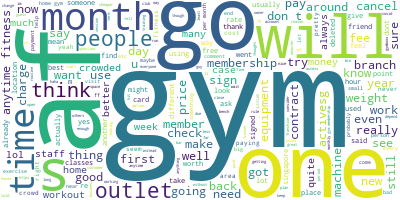

In [25]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(comments['Comment_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [ ]:
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


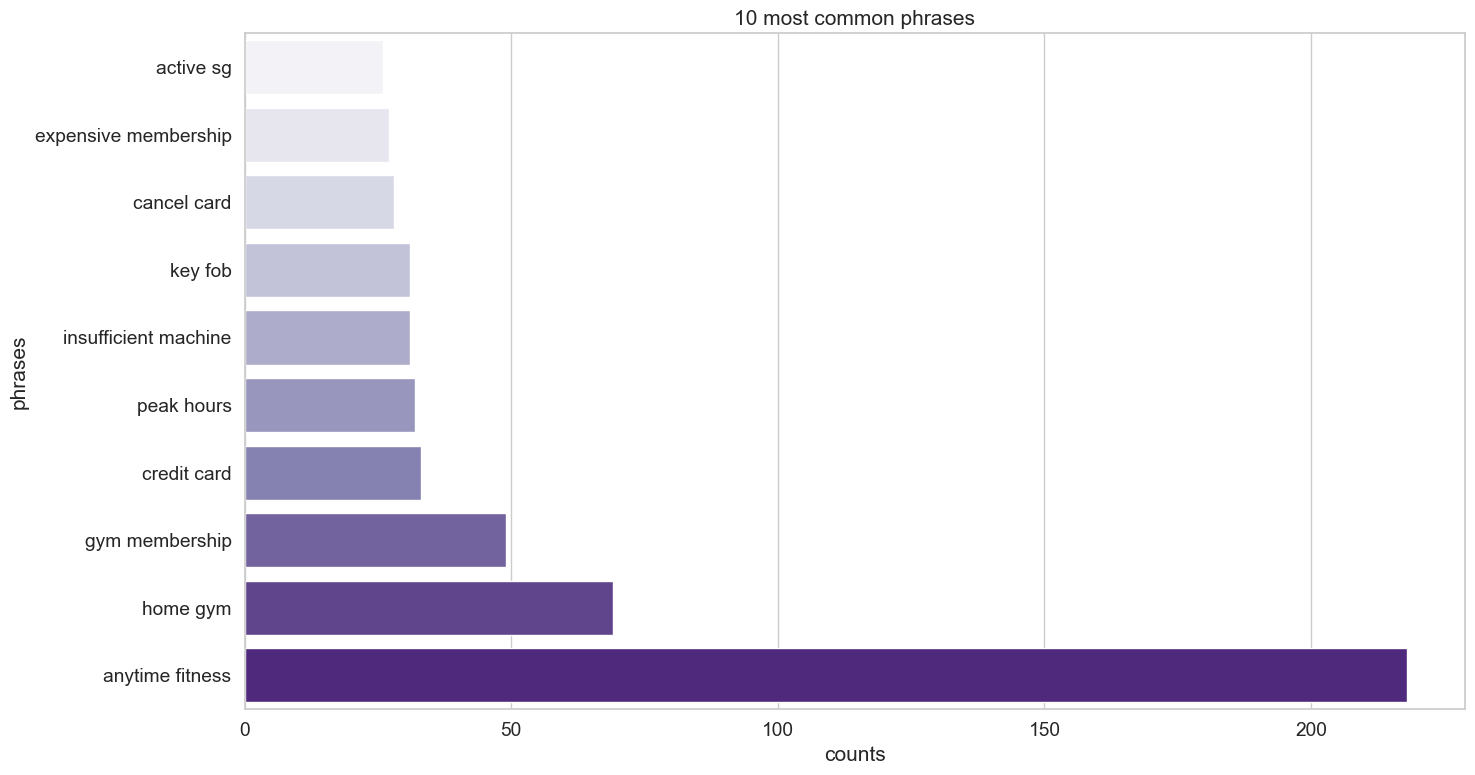

In [28]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Helper function (REPLACE your existing one with this)
def plot_top_phrases(count_data, count_vectorizer, top_k=20, exclude=None, regex_exclude=None):
    """
    exclude: list of exact phrases (as produced by your vectorizer) to drop
    regex_exclude: optional regex pattern; any phrase matching will be dropped
    """
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    words = count_vectorizer.get_feature_names_out()
    # fast total counts across all docs
    total_counts = np.asarray(count_data.sum(axis=0)).ravel()

    pairs = list(zip(words, total_counts))

    # drop exact phrases
    if exclude:
        ban = {p.lower() for p in exclude}
        pairs = [(w, c) for (w, c) in pairs if w.lower() not in ban]

    # drop phrases by regex pattern (e.g., r'^(singapore|anytime fitness)')
    if regex_exclude:
        pat = re.compile(regex_exclude, flags=re.IGNORECASE)
        pairs = [(w, c) for (w, c) in pairs if not pat.search(w)]

    # sort and keep top_k
    pairs.sort(key=lambda x: x[1], reverse=True)
    top = pairs[:top_k]

    words_plot = [w for (w, _) in top][::-1]
    counts_plot = [c for (_, c) in top][::-1]

    plt.figure(2, figsize=(15, 8))
    plt.subplot(title=f'{top_k} most common phrases')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Purples", n_colors=len(counts_plot))  # light → dark
    sns.barplot(x=counts_plot, y=words_plot, palette=palette)
    plt.xlabel('counts')
    plt.ylabel('phrases')
    plt.tight_layout()
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 3)) # <- changed to be phrases instead of words

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(comments['Comment_processed'])

# Visualise the 10 most common words
plot_top_phrases(
    count_data, count_vectorizer,
    top_k=10,
    exclude=["relatively new", "don know"]
)

### LDA model tranining

To keep things simple, we will only tweak the number of topic parameters.

In [27]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
anytime fitness raffles place 24 fitness years ago peak hours home gym city hall feel like going gym credit card

Topic #1:
anytime fitness home gym credit card sign af https wwwyoutubecom 24 hours peak hours chai chee hit gym know af

Topic #2:
anytime fitness chai chee new gym tailgating fee activesg gym key fob gym members social media gym membership mr tan

Topic #3:
relatively new compose asksingapore questions compose asksingapore action performed removed account action performed automatically contact moderators subreddit moderators subreddit message asksingapore questions performed automatically

Topic #4:
anytime fitness home gym cancel card af gyms olympic lifting deaths week social media 12 months squat rack need pay

Topic #5:
insufficient machine anytime fitness make sure activesg gym credit card squat racks 18 months months contract new club financial model

Topic #6:
anytime fitness home gym active sg month notice gym membership don know f

### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

Before runnnig code below, first you need to:
pip install pyLDAvis



In [16]:
%pip install pyLDAvis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.6 MB 8.3 MB/s eta 0:00:01
   ------------------------------------ --- 2.4/2.6 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   -- ------------------------------------- 1.3/24.4 MB 5.6 MB/s eta 0:00:05
   --- ------------------------------------ 2.4/24.4 MB 5.4 MB/s eta 0:00:05
   ----- ---------------------------------- 3.4/24.4 MB 5.2 MB/s eta 0:00:05
   ------- -------------------------------- 4.7/24.4 MB 5.2 MB/s eta 0:00:04
   --------- ------------------------------ 5.5/24.4 MB 4.9 MB/s eta 0:00:04
   ---------- ----------------------------- 6.3/24.4 MB 4.8 MB/s eta 0:00:04
   ------------ --------------------------- 7.3/24.4 MB 4.7 MB/s eta 0:00:04
   ------------- -------------------------- 8.4/24.4 MB 4.6 MB/s eta 0:00:04
   --------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
%%time
import warnings
import os
import pyLDAvis
import pyLDAvis.lda_model
import pickle 

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

try:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
except FileNotFoundError:
    print(f"File not found: {LDAvis_data_filepath}. Preparing data instead.")
    LDAvis_prepared = pyLDAvis.lda_model.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Save the visualization as HTML
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

File not found: ./ldavis_prepared_10. Preparing data instead.
CPU times: total: 2.28 s
Wall time: 16.8 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.139245  0.069241       1        1  24.463900
5     -0.047522 -0.051131       2        1  13.878266
1     -0.066616  0.002924       3        1  13.122614
6     -0.068451  0.011414       4        1  11.164858
2     -0.028449  0.013216       5        1  10.801687
8      0.025388 -0.056467       6        1   6.993117
0      0.010873 -0.030281       7        1   6.328319
9     -0.021613  0.009886       8        1   5.305870
4      0.184913  0.170738       9        1   4.313988
7      0.150721 -0.139540      10        1   3.627382, topic_info=         Term        Freq       Total Category  logprob  loglift
5500  removed   66.000000   66.000000  Default  30.0000  30.0000
463        af  588.000000  588.000000  Default  29.0000  29.0000
1902  deleted   58.000000   58.000000  Default  28.0000  28.0000
2616  fitness  288.000000  288.000000  Default  27.0000  27.0000
602   anytime  241.000000  241.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2102      don    5.326547  320.148323  Topic10  -5.8513  -0.7794
3883     like    5.284401  386.032079  Topic10  -5.8593  -0.9745
895    better    4.686972   98.486579  Topic10  -5.9793   0.2715
2         100    4.422558   54.545797  Topic10  -6.0373   0.8043
4019  machine    4.425195   64.076729  Topic10  -6.0367   0.6439

[751 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2         1  0.329998   100
2         2  0.073333   100
2         3  0.183332   100
2         4  0.018333   100
2         5  0.109999   100
...     ...       ...   ...
7454      1  0.135891  yoga
7454      3  0.090594  yoga
7454      4  0.271782  yoga
7454      6  0.045297  yoga
7454      8  0.407673  yoga

[2054 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 7, 3, 9, 1, 10, 5, 8])

### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this post addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### Sources:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
